In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-05-20 15:26:25.195372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Generate data paths with labels
data_dir = 'dataset_kaggle' 
# Initialize empty lists to store file paths and labels

filepaths = []
labels = []
# Get a list of subdirectories 
folds = []
# Loop over items in the folder
for item in os.listdir(data_dir):
    item_path = os.path.join(data_dir, item)
    # Check if it's a directory
    if os.path.isdir(item_path):
        folds.append(item)

# Iterate over each fold in the dataset 
for fold in folds:

    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
# Iterate over each file in the current fold
    for file in flist:
        fpath = os.path.join(f"dataset_kaggle/{fold}/{file}")
        filepaths.append(fpath)
# Determine the label based on the subdirectory (f)
        #print(file)
        if 'lungaca' in file:
            labels.append('Lung Adenocarcinoma')
        elif 'lungn' in file:
            labels.append('Lung Benign Tissue')
        elif 'lungscc' in file:
            labels.append('Lung Squamous Cell Carcinoma')


# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1) 

In [17]:
df

,filepaths,labels
0,dataset_kaggle/lung_aca/lungaca2296.jpeg,Lung Adenocarcinoma
1,dataset_kaggle/lung_aca/lungaca1843.jpeg,Lung Adenocarcinoma
2,dataset_kaggle/lung_aca/lungaca294.jpeg,Lung Adenocarcinoma
3,dataset_kaggle/lung_aca/lungaca3487.jpeg,Lung Adenocarcinoma
4,dataset_kaggle/lung_aca/lungaca4342.jpeg,Lung Adenocarcinoma
...,...,...
14995,dataset_kaggle/lung_scc/lungscc203.jpeg,Lung Squamous Cell Carcinoma
14996,dataset_kaggle/lung_scc/lungscc4711.jpeg,Lung Squamous Cell Carcinoma
14997,dataset_kaggle/lung_scc/lungscc1513.jpeg,Lung Squamous Cell Carcinoma
14998,dataset_kaggle/lung_scc/lungscc2295.jpeg,Lung Squamous Cell Carcinoma


In [18]:
labels = df['labels']
train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=26, stratify=labels)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=26, stratify=temp_df['labels']) 

In [19]:
train_df

,filepaths,labels
2412,dataset_kaggle/lung_aca/lungaca3072.jpeg,Lung Adenocarcinoma
84,dataset_kaggle/lung_aca/lungaca2412.jpeg,Lung Adenocarcinoma
12437,dataset_kaggle/lung_scc/lungscc2198.jpeg,Lung Squamous Cell Carcinoma
8844,dataset_kaggle/lung_n/lungn1273.jpeg,Lung Benign Tissue
5999,dataset_kaggle/lung_n/lungn4176.jpeg,Lung Benign Tissue
...,...,...
12354,dataset_kaggle/lung_scc/lungscc2634.jpeg,Lung Squamous Cell Carcinoma
9968,dataset_kaggle/lung_n/lungn1233.jpeg,Lung Benign Tissue
3044,dataset_kaggle/lung_aca/lungaca2945.jpeg,Lung Adenocarcinoma
14558,dataset_kaggle/lung_scc/lungscc2722.jpeg,Lung Squamous Cell Carcinoma


In [20]:
# Define image size, channels, and shape
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerator  for training and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Training data generator
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# Validation data generator
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# Testing data generator
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


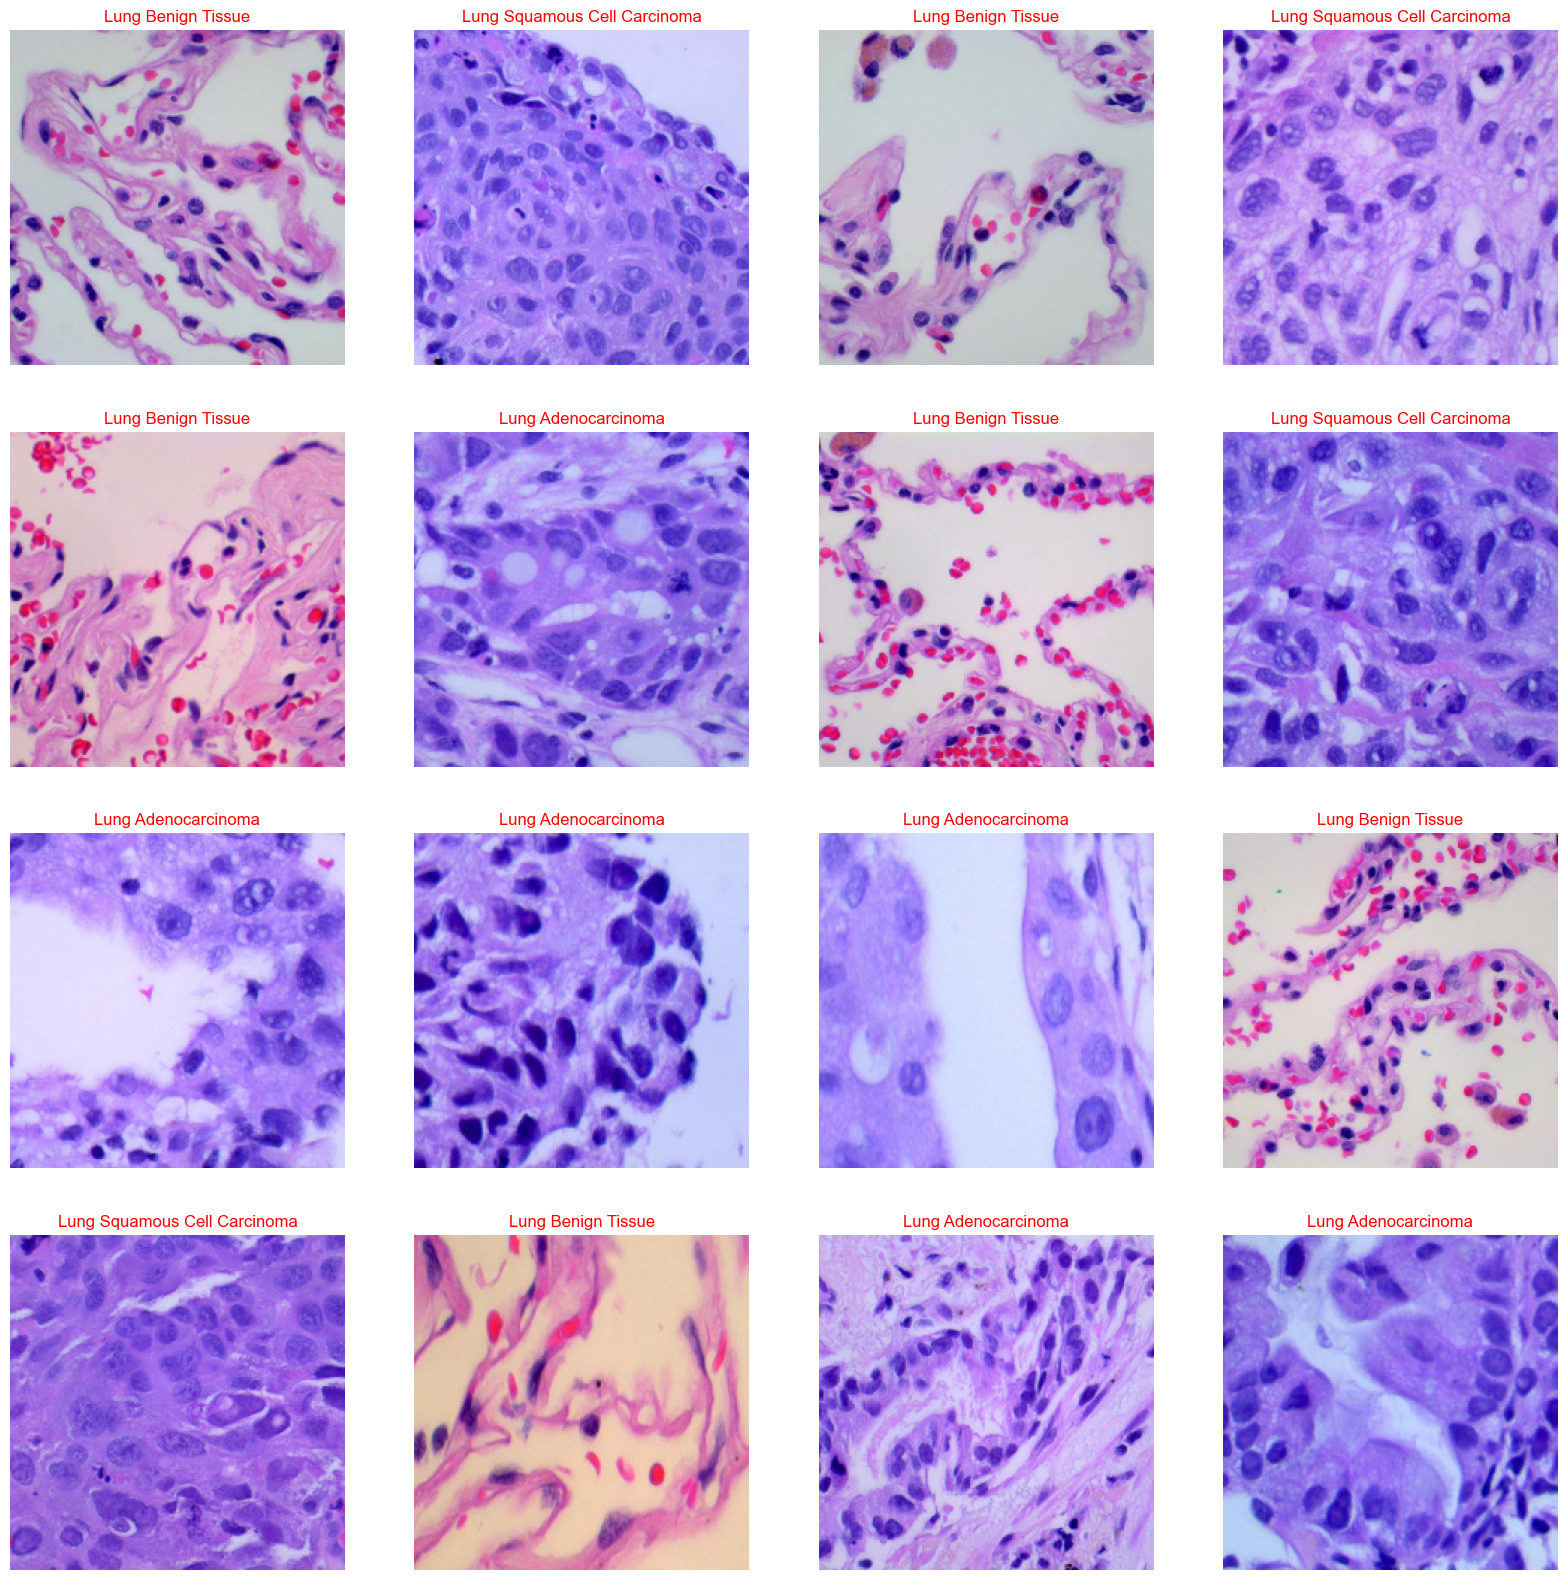

In [21]:
# Get the class Name from the training generator
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)
    
    image = images[i] / 255 
    
    plt.imshow(image)
    
    index = np.argmax(labels[i])
  
    class_name = classes[index]
    
    plt.title(class_name, color='red', fontsize=12)
    
    plt.axis('off')

plt.show()

What about the colours?

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import Xception 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.models import Model 

In [26]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [27]:
def get_callbacks(model_name):
    callbacks = []

    # Use correct syntax for ModelCheckpoint
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_accuracy', mode='max') 
    callbacks.append(checkpoint) 

    # Import ReduceLROnPlateau if not imported earlier
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)

    # Import EarlyStopping if not imported earlier
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)

    return callbacks 

In [28]:
# Create Xception base model
base_model = Xception(input_shape=img_shape, include_top=False, weights='imagenet')

base_model.trainable = True

x = base_model.output

x = GlobalAveragePooling2D()(x)

y = Dense(256, activation='relu')(x)

predictions = Dense(class_count, activation='softmax', name='final')(y)

model_Xception = Model(inputs=base_model.input, outputs=predictions)  


model_Xception.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
callbacks=get_callbacks('Xception') 
history_Xception=model_Xception.fit(train_gen,epochs=10,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/10


2024-05-20 15:37:15.452668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 48/188 [======>.......................] - ETA: 1:19:00 - loss: 0.1448 - accuracy: 0.9388

KeyboardInterrupt: 